In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

import h5py
import numpy as np
from magtense.utils import plot_M_thin_film

from koopmag.database import create_db_mp
from koopmag.utils import plot_dynamics

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax) -> None:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

In [2]:
datapath = Path().cwd().parent / "data"

try:
    db = h5py.File(datapath / "20_200_36_9.h5", "r")
    print("Successfully loaded data")

    print("Attributes of database:")
    for key in db.attrs:
        print(f"{key}: {db.attrs[key]}")

    print("\nData in the database:")
    for key in db:
        print(f"{key}: {db[key].shape}")

    # extract external fields
    Hs = np.array(db["field"])

    # extract data
    DATA = np.array(db["sequence"])

    db.close()

except FileNotFoundError:
    print("Database not found. Please try again.")

Successfully loaded data
Attributes of database:
grid_size: [5.00e-07 1.25e-07 3.00e-09]
h_ext_angle: [  0 360]
h_ext_norm: [ 0 50]
res: [36  9  1]
seed: 0
t_per_step: 1e-11
t_steps: 200

Data in the database:
field: (20, 3)
sequence: (20, 200, 36, 9, 3)


In [3]:
# switch data dimensions to match pytorch conv layer
#   (n_seq, n_tsteps, n_x, n_y, 3) -> (n_seq, n_tsteps, 3, n_x, n_y)
data = np.permute_dims(DATA, (0, 1, 4, 2, 3))
print(f"Data shape: {data.shape} (n_seq, n_tsteps, 3, n_x, n_y)")
# define data dimensions
n_seq, n_tsteps, data_dim = *data.shape[:2], data.shape[2:]

Xs = data[:, :-1, :, :, :]
Ys = data[:,  1:, :, :, :]

print(f"Xs shape: {Xs.shape} (n_seq, n_tsteps - 1, 3, n_x, n_y)")
print(f"Ys shape: {Xs.shape} (n_seq, n_tsteps - 1, 3, n_x, n_y)")

db.close()

Data shape: (20, 200, 3, 36, 9) (n_seq, n_tsteps, 3, n_x, n_y)
Xs shape: (20, 199, 3, 36, 9) (n_seq, n_tsteps - 1, 3, n_x, n_y)
Ys shape: (20, 199, 3, 36, 9) (n_seq, n_tsteps - 1, 3, n_x, n_y)


In [4]:
Xtorch = torch.tensor(Xs, dtype=torch.float32)
Ytorch = torch.tensor(Ys, dtype=torch.float32)

Htorch = torch.stack(
    [
        torch.stack(
            [torch.tensor(Hs[i], dtype=torch.float32) for _ in range(n_tsteps - 1)]
        )
        for i in range(n_seq)
    ]
)

print(f"H shape: {Htorch.shape} (n_seq, n_tsteps - 1, 3)")

H shape: torch.Size([20, 199, 3]) (n_seq, n_tsteps - 1, 3)


### Koopman Autoencoder

In [5]:
class CNNEncoder(nn.Module):
    def __init__(self, conv_chns=(3, 16, 32, 64), act_fn=nn.ReLU) -> None:
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            # Input: (in_channels, 36, 9)
            nn.Conv2d(conv_chns[0], conv_chns[1], kernel_size=3, padding=1),        # -> (ch1, 36, 9)
            nn.BatchNorm2d(conv_chns[1]),
            act_fn(),
            nn.MaxPool2d(kernel_size=(3,3)),                                        # -> (ch1, 12, 3)
            
            nn.Conv2d(conv_chns[1], conv_chns[2], kernel_size=3, padding=1),        # -> (ch2, 12, 3)
            nn.BatchNorm2d(conv_chns[2]),
            act_fn(),
            nn.MaxPool2d(kernel_size=(2,3)),                                        # -> (ch2, 6, 1)
            
            nn.Conv2d(conv_chns[2], conv_chns[3], kernel_size=3, padding=1),        # -> (ch3, 6, 1)
            nn.BatchNorm2d(conv_chns[3]),
            act_fn(),
            nn.MaxPool2d(kernel_size=(2,1))                                         # -> (ch3, 3, 1)
        )

    def forward(self, x) -> torch.Tensor:
        return self.encoder(x)
        
class CNNDecoder(nn.Module):

    def __init__(self, conv_chns=(3, 16, 32, 64), act_fn=nn.ReLU) -> None:
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(conv_chns[3], conv_chns[2], kernel_size=(2,1), stride=(2,1)),  # -> (ch2, 6, 1)
            nn.BatchNorm2d(conv_chns[2]),
            act_fn(),
            
            nn.ConvTranspose2d(conv_chns[2], conv_chns[1], kernel_size=(2,3), stride=(2,3)),  # -> (ch1, 12, 3)
            nn.BatchNorm2d(conv_chns[1]),
            act_fn(),
            
            nn.ConvTranspose2d(conv_chns[1], conv_chns[0], kernel_size=(3,3), stride=(3,3)),  # -> (in_channels, 36, 9)
        )

    def forward(self, x) -> torch.Tensor:
        return self.decoder(x)
        

class DeepKoopman(nn.Module):

    def __init__(self, conv_chns, latent_dim, act_fn=nn.ReLU, learn_A=False) -> None:
        super().__init__()
        
        self.conv_chns = conv_chns
        self.latent_dim = latent_dim
        self.learn_A = learn_A

        self.encoder = CNNEncoder(conv_chns=conv_chns, act_fn=act_fn)
        self.flatten = nn.Flatten()
        self.fc_encode = nn.Linear(conv_chns[-1] * 3, latent_dim) # shape (64*3, d)

        self.fc_decode = nn.Linear(latent_dim, conv_chns[-1] * 3) # shape (d, 64*3)
        self.decoder = CNNDecoder(conv_chns=conv_chns, act_fn=act_fn)

        if learn_A:
            self.A = nn.Linear(latent_dim, latent_dim, bias=False) # shape (d, d)
        else:
            self.register_buffer("A", torch.empty(latent_dim, latent_dim)) # shape (d, d)

        self.B = nn.Linear(3, latent_dim, bias=False) # shape (n_magnetization, d)



    def encode(self, x) -> torch.Tensor:
        x = self.encoder(x)    # encode X: (n x m)  -> Xtilde: (n x d)
        x = self.flatten(x)    # flatten Xtilde: (n x d)
        x = self.fc_encode(x)
        return x
    

    def decode(self, x) -> torch.Tensor:
        x = self.fc_decode(x)
        x = x.view(-1, self.conv_chns[-1], 3, 1) # reshape to (n x 64 x 3 x 1)
        x = self.decoder(x)    # decode Xtilde: (n x d)  -> X: (n x m)
        return x


    def compute_linear_operator_pinv(self, Xtilde, Ytilde) -> None:
        A = torch.linalg.pinv(Xtilde, rcond=1e-4) @ Ytilde
        self.A.data.copy_(A)
    

    def compute_linear_operator_tikh(self, Xtilde, Ytilde, lam=1e-1) -> None:
    # Xtilde: (n, d), Ytilde: (n, d)
        XtX = Xtilde.T @ Xtilde             # (d, d)
        d   = XtX.shape[0]
        reg = lam * torch.eye(d, device=XtX.device)
        A   = torch.linalg.solve(XtX + reg, Xtilde.T @ Ytilde)
        self.A.data.copy_(A)


    def forward(self, X, Y, U) -> tuple[torch.Tensor, torch.Tensor]:
        '''
        params:
        X: input data (n x m)
        Y: target data (n x m)
        U: external effect (n x 3)
        '''
        T = X.shape[0]
        T_half = T // 2
        Xtilde = self.encode(X)    # encode X: (n x m)  -> Xtilde: (n x d)
        Ytilde = self.encode(Y)    # encode Y: (n x m)  -> Ytilde: (n x d)

        ext_effect = self.B(U[:T_half, :])  # shape (n//2 x d)

        # compute linear operator according to 
        # A = (Ytilde - B @ U) @ Xtilde^+
        if not self.learn_A:
            self.compute_linear_operator_tikh(
                Xtilde[:T_half,:], Ytilde[:T_half,:] - ext_effect
                )

            Ytilde_pred_list = [Xtilde[0] @ self.A + self.B(U[0,:])] 
            for t in range(1, T):
                next_pred = Ytilde_pred_list[t-1] @ self.A + self.B(U[t,:])
                Ytilde_pred_list.append(next_pred)
        else:
            Ytilde_pred_list = [self.A(Xtilde[0]) + self.B(U[0,:])] 
            for t in range(1, T):
                next_pred = self.A(Ytilde_pred_list[-1]) + self.B(U[t,:])
                Ytilde_pred_list.append(next_pred)
        
        Ytilde_pred = torch.stack(Ytilde_pred_list, dim=0)
        
        Xhat = self.decode(Xtilde)
        Yhat = self.decode(Ytilde_pred)

        return Xhat, Yhat
    
    
    def predict(self, X, T, U) -> torch.Tensor:
        if len(X.shape) == 1:
            X = X.unsqueeze(0)  # make it (1, input_dim)

        with torch.no_grad():
            Xtilde0 = self.encode(X)    # encode X: (n x m)  -> Xtilde: (n x d)
            Ytilde_pred = torch.zeros((T, Xtilde0.shape[1])).to(Xtilde0.device)

            # If A is computed using pseudo-inverse or tikhonov regularization:
            if not self.learn_A:
                Ytilde_pred[0] = Xtilde0 @ self.A + self.B(U[0,:])
                for t in range(1, T):
                    Ytilde_pred[t] = Ytilde_pred[t-1] @ self.A + self.B(U[t,:])

            # If A is learned as a parameter:
            else:
                Ytilde_pred[0] = self.A(Xtilde0) + self.B(U[0,:])
                for t in range(1, T):
                    Ytilde_pred[t] = self.A(Ytilde_pred[t-1]) + self.B(U[t,:])
  
            Yhat = self.decode(Ytilde_pred)
        return Yhat

In [6]:
m = int(np.prod(data_dim))  # input dimension
conv_chns = (3, 32, 64, 128) # conv channels
latent_dim = 4

act_fn = nn.ReLU            # activation function in autoencoder

LEARN_A = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepKoopman(conv_chns=conv_chns, 
                    latent_dim=latent_dim, 
                    act_fn=act_fn,
                    learn_A=LEARN_A).to(device)

criterion = nn.MSELoss()

In [155]:
dummy_data1 = torch.ones((50, 3, 36, 9)).to(device)
dummy_data2 = torch.ones((50, 3, 36, 9)).to(device)
dummy_data3 = torch.ones((50, 3)).to(device)

x_dummy, y_dummy = model(dummy_data1, dummy_data2, dummy_data3)
x_dummy.shape, y_dummy.shape

(torch.Size([50, 3, 36, 9]), torch.Size([50, 3, 36, 9]))

In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 100
print_every = 10
n_rep = 1

losses = np.zeros(epochs)

for epoch in range(epochs):

    running_loss = 0.0
    for batch in range(1):
        for _ in range(n_rep):
            Xtrain = Xtorch[batch].to(device)
            Ytrain = Ytorch[batch].to(device)
            U = Htorch[batch].to(device)

            model.train()
            optimizer.zero_grad()

            Xhat, Yhat = model(Xtrain, Ytrain, U=U)

            loss = 5 * criterion(Xhat, Xtrain) + criterion(Yhat, Ytrain)

            loss.backward()
            optimizer.step()
            
        running_loss += loss.item()
    
    losses[epoch] = running_loss / n_seq

    if epoch % print_every == print_every - 1:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 10, Loss: 0.11005143821239471
Epoch 20, Loss: 0.09237655997276306
Epoch 30, Loss: 0.08223487436771393
Epoch 40, Loss: 0.07608594000339508
Epoch 50, Loss: 0.07101090252399445
Epoch 60, Loss: 0.06769943237304688
Epoch 70, Loss: 0.06418248265981674
Epoch 80, Loss: 0.0618392638862133
Epoch 90, Loss: 0.06013946235179901
Epoch 100, Loss: 0.05760112404823303


In [10]:
# Check the autoencoder works as intended
model.eval()
with torch.no_grad():
    Xtest = Xtorch[0].to(device)
    Ytest = Ytorch[0].to(device)
    U = Htorch[0].to(device)

    Xtilde = model.encode(Xtest)
    Xhat = model.decode(Xtilde).detach().cpu().numpy().reshape((n_tsteps-1, -1))
    Xtrue = Xtest.cpu().numpy().reshape((n_tsteps-1, -1))

    error = (np.linalg.norm(Xhat - Xtrue, axis=1) / np.linalg.norm(Xtrue, axis=1))
error.shape

(199,)

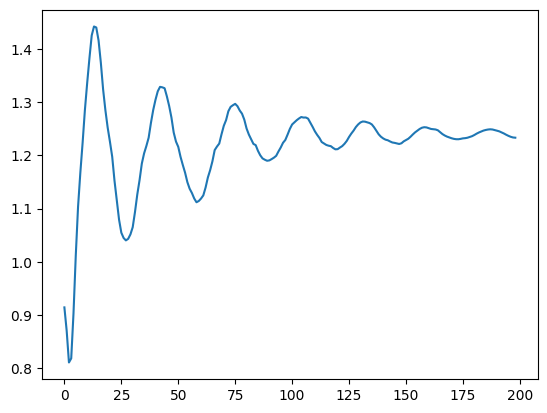

In [11]:
plt.plot(error)

In [157]:
errors = np.zeros((n_seq, n_tsteps - 1))

model.eval()

Ypreds = []

for i in range(n_seq):
    Xinit = Xtorch[i, 0].to(device)
    U = Htorch[i].to(device)

    Yhat = model.predict(Xinit[None,:,:,:], n_tsteps - 1, U=U).cpu().detach().numpy()

    Ypreds.append(Yhat)

    Ytrain = Ytorch[i].detach().cpu().numpy()

    errors[i] = (np.linalg.norm(Yhat.reshape((n_tsteps-1, -1)) - Ytrain.reshape((n_tsteps-1, -1)), axis=1) 
                / np.linalg.norm(Ytrain.reshape((n_tsteps-1, -1)), axis=1))

In [158]:
Ypreds = np.array(Ypreds)
Ypreds = np.permute_dims(Ypreds, (0, 1, 3, 4, 2))

In [159]:
Ypreds.shape

(100, 199, 36, 9, 3)

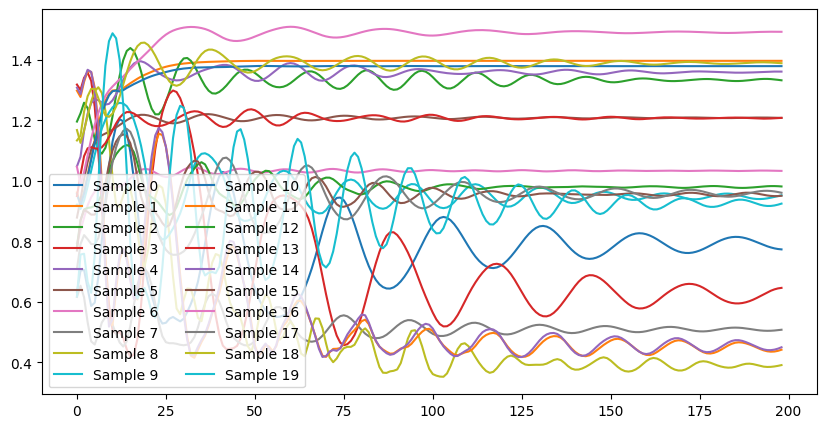

In [161]:
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(min(20, n_seq)):
    ax.plot(errors[i], label=f"Sample {i}")
ax.legend(ncol=2)
plt.show()

In [162]:
DATA.shape, Ypreds.shape

((100, 200, 36, 9, 3), (100, 199, 36, 9, 3))


Field 5:
[40.78664    0.7018647  0.       ]


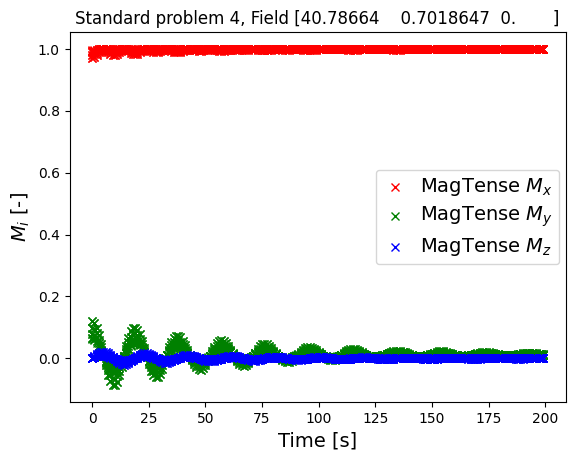

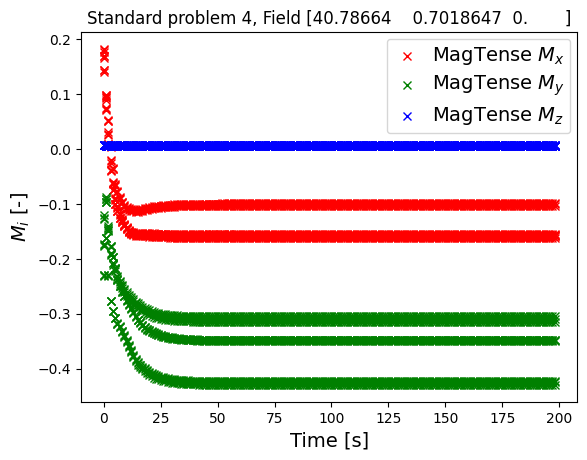

In [163]:
field_idx = 5
print(f"\nField {field_idx}:\n{Hs[field_idx]}")
plot_dynamics(
    np.arange(DATA[field_idx].shape[0]),
    DATA[field_idx],
    field=Hs[field_idx],
)
plot_dynamics(
    np.arange(Ypreds[field_idx].shape[0]),
    Ypreds[field_idx],
    field=Hs[field_idx],
)